Import 

In [34]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

Read Files

In [35]:
df_response = pd.read_csv('https://raw.githubusercontent.com/WannidaSut/BADS7105/671e4515cc1bc0bf0abe4441adaa94ee358586de/Homework-08/Retail_Data_Response.csv')
df_transactions = pd.read_csv('https://raw.githubusercontent.com/WannidaSut/BADS7105/671e4515cc1bc0bf0abe4441adaa94ee358586de/Homework-08/Retail_Data_Transactions.csv'
                              ,parse_dates=['trans_date'])
df_response.head(10)
df_transactions.head(10)

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78
5,CS5539,2014-03-26,81
6,CS2724,2012-02-06,93
7,CS5902,2015-01-30,89
8,CS6040,2013-01-08,76
9,CS3802,2013-08-20,75


Prepare Data

In [36]:
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent'] = campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent'] = df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head(10)
df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      
                                                     'customer_id': lambda x: len(x),                 
                                                     'tran_amount': lambda x: x.sum()})                       
df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)
df_rfm = df_rfm.reset_index()
df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      
                                                     'customer_id': lambda x: len(x),                 
                                                     'tran_amount': lambda x: x.sum(),                          
                                                     'trans_date': lambda x: (x.max() - x.min()).days})      
df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)
df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']
df_clv = df_clv.reset_index()
df_group_response = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()

Train

In [37]:
response_rfm = pd.merge(df_response,df_rfm)
response_clv = pd.merge(df_response,df_clv)

X_rfm = response_rfm.drop(columns=['response','customer_id'])
y_rfm = response_rfm['response']

X_clv = response_clv.drop(columns=['response','customer_id'])
y_clv = response_clv['response']

Test

In [38]:
X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=10)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=10)

Visual

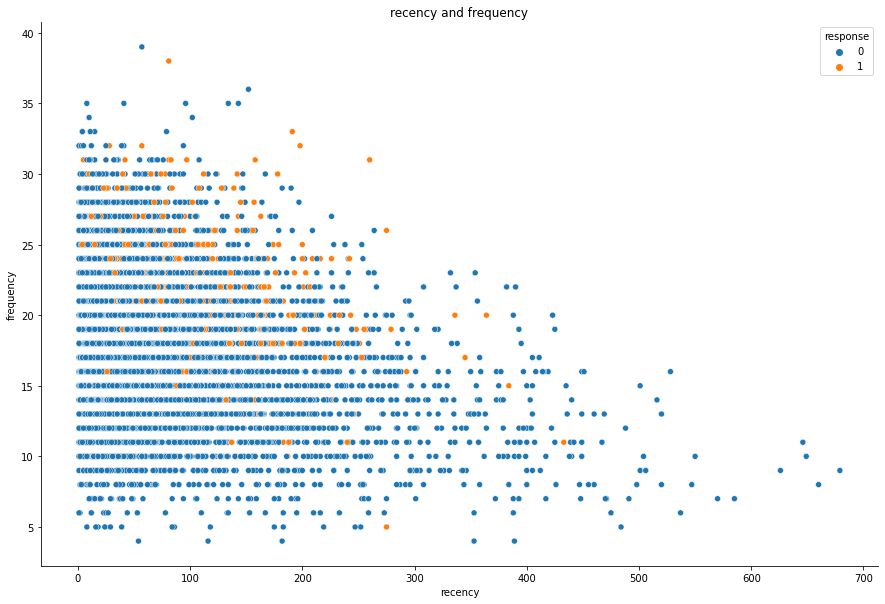

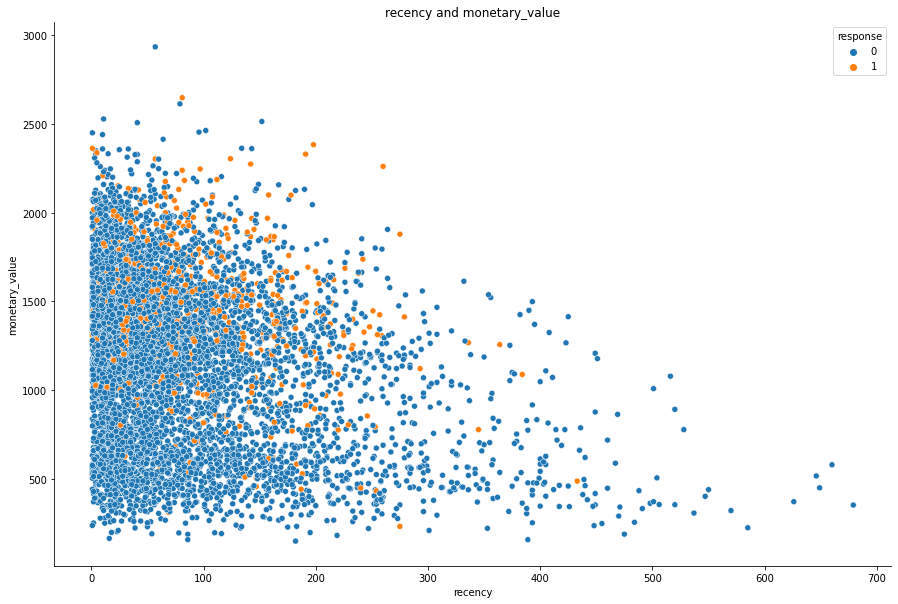

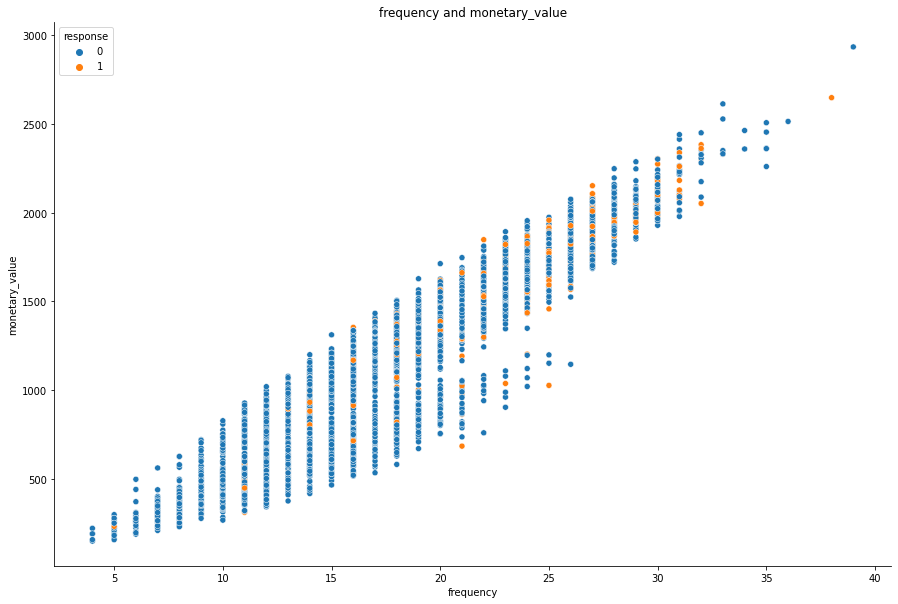

In [39]:
for i, col_i in enumerate(response_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(response_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.figure(figsize=(15,10))
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=response_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

Smooth

In [40]:
sm = SMOTE(random_state=10)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Regression SMOTE RFM'

In [41]:
predicted_y = []
expected_y = []

model_lr_rfm = LogisticRegression(solver='liblinear', class_weight='balanced')
model_lr_rfm = model_lr_rfm.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = model_lr_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('Training Set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = model_lr_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('Test Set')
print(report_test) 

Training Set
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      4373
           1       0.66      0.70      0.68      4373

    accuracy                           0.67      8746
   macro avg       0.67      0.67      0.67      8746
weighted avg       0.67      0.67      0.67      8746

Test Set
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      1864
           1       0.17      0.68      0.27       202

    accuracy                           0.64      2066
   macro avg       0.56      0.66      0.51      2066
weighted avg       0.87      0.64      0.71      2066



Logistic Regression SMOTE CLV

In [42]:
predicted_y = []
expected_y = []

model_lr_clv = LogisticRegression(solver='liblinear', class_weight='balanced')
model_lr_clv = model_lr_clv.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = model_lr_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('Training Set')
print(report_train) 

predicted_y = []
expected_y = []

predictions = model_lr_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('Test Set')
print(report_test) 

Training Set
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      4373
           1       0.65      0.69      0.67      4373

    accuracy                           0.66      8746
   macro avg       0.66      0.66      0.66      8746
weighted avg       0.66      0.66      0.66      8746

Test Set
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      1864
           1       0.17      0.69      0.27       202

    accuracy                           0.64      2066
   macro avg       0.56      0.66      0.51      2066
weighted avg       0.87      0.64      0.71      2066

